In [1]:
%pwd

'/home/vinay/fastai/courses/dl1'

In [2]:
import pandas as pd

In [3]:
PATH = '/home/vinay/fastai/bee/dataset/images/'
%ls {PATH}


models/  SubmissionFormat.csv  test/  tmp/  train/  train_labels.csv


In [4]:
'data + train_labels.csv'

'data + train_labels.csv'

In [29]:
pd.read_csv(f'{PATH}/SubmissionFormat.csv')

,id,genus
0,2783,0.5
1,2175,0.5
2,4517,0.5
3,2831,0.5
4,3556,0.5
5,3111,0.5
6,3113,0.5
7,3962,0.5
8,1664,0.5
9,2443,0.5


In [5]:
import os
data = pd.read_csv(f'{PATH}/train_labels.csv')
data.head()

,id,genus
0,520,1.0
1,3800,1.0
2,3289,1.0
3,2695,1.0
4,4922,1.0


In [6]:
n = len(list(os.listdir(f'{PATH}/train')))


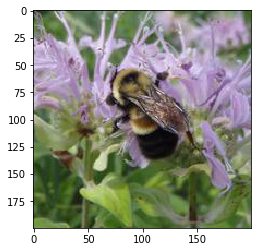

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
images = f'{PATH}/train'
img = plt.imread(f'{images}/1259.jpg')
plt.imshow(img)

In [8]:
data.pivot_table(index = 'genus',aggfunc=len)

,id
genus,
0.0,827
1.0,3142


In [9]:
from fastai.conv_learner import *
from fastai.model import *
from fastai.plots import *
from fastai.transforms import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.torch_imports import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *

In [10]:
val_idxs = get_cv_idxs(n)

In [11]:
#in the following cells i include the actual code in the library that provides 

In [ ]:
#def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [12]:
#the data seems to be slightly skewed,i don't think i should a network from scratch

bs = 15
sz = 180
arch = resnet34
tfms = tfms_from_model(arch ,sz,aug_tfms = transforms_side_on,max_zoom = 1.1)
data = ImageClassifierData.from_csv(PATH,'train',f'{PATH}train_labels.csv',
                                    tfms = tfms,bs = bs,suffix = '.jpg',val_idxs = val_idxs,test_name='test')
#just makes the dataloading a bit more easier than pytorch.bs - batch size,sz -size of the image 180 * 180

In [13]:

bee = PATH+data.trn_ds.fnames[12]
img = PIL.Image.open(bee)

In [14]:
img.size

(200, 200)

In [15]:
torch.cuda.is_available()

True

In [16]:
#now let's use learning rate scheduler...taken from leslie smith's paper cyclical learning rates -- linked....

learn = ConvLearner.pretrained(arch,data,precompute = True)
lrf = learn.lr_find()      

  0%|          | 1/212 [00:00<00:35,  6.02it/s]

/home/vinay/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 67/67 [00:01<00:00, 34.42it/s]


  4%|▍         | 9/212 [00:00<00:05, 37.82it/s, loss=tensor(1.0298, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


 74%|███████▎  | 156/212 [00:00<00:00, 210.03it/s, loss=tensor(2.7572, device='cuda:0')]


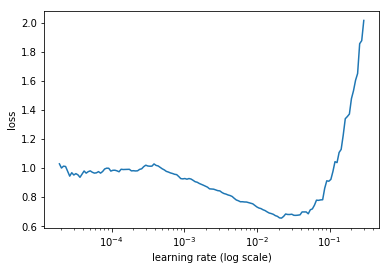

In [17]:
learn.sched.plot()

In [18]:
#so let's set the learning rate  as 0.035
lr = 0.03
learn.fit(lr,1)

  3%|▎         | 6/212 [00:00<00:07, 28.28it/s, loss=tensor(0.7505, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                               
    0      0.778094   0.606529   0.847412  



[0.60652864, 0.8474117]

In [19]:
learn.save('withprecompute')


In [20]:
learn.load('withprecompute')

In [21]:
learn.precompute = False   #now precompute is made fase i.e only final layers weights are variables or differentiable.

In [22]:
learn.fit(lr, 3, cycle_len=1)       #refer cyclical l.r paper - leslie smith.

  1%|▏         | 3/212 [00:00<00:20, 10.11it/s, loss=tensor(0.9608, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      0.407195   0.242195   0.895404  
    1      0.349566   0.217088   0.901887                                              
    2      0.302194   0.229473   0.892888                                              



[0.22947274, 0.8928882]

In [23]:
learn.save('firstiteration')
learn.load('firstiteration')

In [24]:
learn.fit(lr,3,cycle_len=1)
learn.save('second')
learn.load('second')

  1%|▏         | 3/212 [00:00<00:24,  8.66it/s, loss=tensor(0.3268, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      0.286586   0.219137   0.907983  
    1      0.27468    0.21495    0.892888                                              
    2      0.285534   0.209141   0.898113                                              



  1%|          | 2/212 [00:00<00:35,  5.95it/s, loss=tensor(0.3031, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy                                              
    0      0.256705   0.143433   0.940881  
    1      0.202916   0.136649   0.940881                                              
    2      0.117605   0.111161   0.957233                                              
    3      0.144404   0.153932   0.931882                                              
 35%|███▍      | 74/212 [00:08<00:16,  8.24it/s, loss=tensor(1.00000e-02 *e='cuda:0')]
 36%|███▌      | 76/212 [00:08<00:16,  8.47it/s, loss=tensor(1.00000e-02 *
 36%|███▌      | 76/212 [00:09<00:16,  8.39it/s, loss=tensor(1.00000e-02 *
 36%|███▌      | 76/212 [00:09<00:16,  8.32it/s, loss=tensor(1.00000e-02 *
 37%|███▋      | 78/212 [00:09<00:15,  8.54it/s, loss=tensor(1.00000e-02 *
 37%|███▋      | 78/212 [00:09<00:15,  8.46it/s, loss=tensor(1.00000e-02 *
 37%|███▋      | 78/212 [00:09<00:15,  8.39it/s, loss=tensor(1.00000e-02 *
 38%|███▊      | 80/212 [00:09<00:15,  8.60it/s, loss=tensor(1.0000

 25%|██▌       | 54/212 [00:07<00:20,  7.64it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 54/212 [00:07<00:20,  7.55it/s, loss=tensor(1.00000e-02 *
 26%|██▋       | 56/212 [00:07<00:19,  7.83it/s, loss=tensor(1.00000e-02 *
 26%|██▋       | 56/212 [00:07<00:20,  7.74it/s, loss=tensor(1.00000e-02 *
 26%|██▋       | 56/212 [00:07<00:20,  7.66it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 58/212 [00:07<00:19,  7.93it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 58/212 [00:07<00:19,  7.84it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 58/212 [00:07<00:19,  7.76it/s, loss=tensor(1.00000e-02 *
 28%|██▊       | 60/212 [00:07<00:18,  8.02it/s, loss=tensor(1.00000e-02 *
 28%|██▊       | 60/212 [00:07<00:19,  7.94it/s, loss=tensor(1.00000e-02 *
 28%|██▊       | 60/212 [00:07<00:19,  7.86it/s, loss=tensor(1.00000e-02 *
 29%|██▉       | 62/212 [00:07<00:18,  8.12it/s, loss=tensor(1.00000e-02 *
 29%|██▉       | 62/212 [00:07<00:18,  8.03it/s, loss=tensor(1.00000e-02 *
 29%|██▉       | 62/212 [

 59%|█████▉    | 126/212 [00:12<00:08,  9.72it/s, loss=tensor(1.00000e-02 *
 60%|██████    | 128/212 [00:12<00:08,  9.88it/s, loss=tensor(1.00000e-02 *
 60%|██████    | 128/212 [00:13<00:08,  9.81it/s, loss=tensor(1.00000e-02 *
 60%|██████    | 128/212 [00:13<00:08,  9.76it/s, loss=tensor(1.00000e-02 *
 61%|██████▏   | 130/212 [00:13<00:08,  9.91it/s, loss=tensor(1.00000e-02 *
 61%|██████▏   | 130/212 [00:13<00:08,  9.85it/s, loss=tensor(1.00000e-02 *
 61%|██████▏   | 130/212 [00:13<00:08,  9.79it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 132/212 [00:13<00:08,  9.94it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 132/212 [00:13<00:08,  9.88it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 132/212 [00:13<00:08,  9.82it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:13<00:07,  9.97it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:13<00:07,  9.91it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:13<00:07,  9.85it/s, loss=tensor(1.00000e-02 *
 64%|██████▍

 93%|█████████▎| 198/212 [00:18<00:01, 10.52it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 200/212 [00:18<00:01, 10.63it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 200/212 [00:18<00:01, 10.58it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 200/212 [00:18<00:01, 10.54it/s, loss=tensor(1.00000e-02 *
 95%|█████████▌| 202/212 [00:18<00:00, 10.64it/s, loss=tensor(1.00000e-02 *
 95%|█████████▌| 202/212 [00:19<00:00, 10.60it/s, loss=tensor(1.00000e-02 *
 95%|█████████▌| 202/212 [00:19<00:00, 10.55it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 204/212 [00:19<00:00, 10.66it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 204/212 [00:19<00:00, 10.61it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 204/212 [00:19<00:00, 10.57it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:19<00:00, 10.67it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:19<00:00, 10.62it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:19<00:00, 10.56it/s, loss=tensor(1.00000e-02 *
 98%|███████

 22%|██▏       | 47/212 [00:06<00:24,  6.76it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:07<00:24,  6.68it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:07<00:23,  6.96it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:07<00:23,  6.88it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:07<00:23,  6.80it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:22,  7.08it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  7.00it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  6.92it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:22,  7.19it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:22,  7.11it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:22,  7.03it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:21,  7.29it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:21,  7.21it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [

 56%|█████▌    | 119/212 [00:13<00:10,  8.87it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:13<00:10,  9.01it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:13<00:10,  8.96it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:13<00:10,  8.90it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  9.04it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  8.98it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  8.92it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  9.07it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  9.01it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  8.95it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:13<00:09,  9.09it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:14<00:09,  9.03it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:14<00:09,  8.97it/s, loss=tensor(1.00000e-02 *
 61%|██████ 

 90%|█████████ | 191/212 [00:19<00:02,  9.66it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:19<00:01,  9.76it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:19<00:01,  9.71it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:19<00:01,  9.67it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:19<00:01,  9.77it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:20<00:01,  9.73it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:20<00:01,  9.69it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:20<00:01,  9.79it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:20<00:01,  9.75it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:20<00:01,  9.70it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:20<00:01,  9.80it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:20<00:01,  9.75it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:20<00:01,  9.71it/s, loss=tensor(1.00000e-02 *
 95%|███████

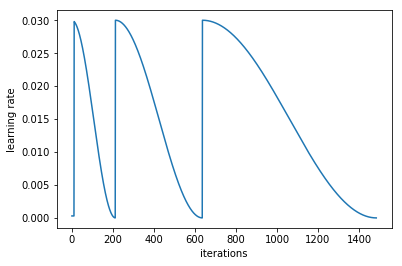

In [25]:
learn.unfreeze()   #now all layers are differentiable
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.sched.plot_lr()

  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:44,  4.78it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:14,  2.84it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:37,  5.61it/s, loss=tensor(1.00000e-02 *
       1.1856, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


  1%|          | 2/212 [00:00<00:52,  4.04it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:34,  5.98it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:44,  4.73it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:33,  6.24it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:39,  5.29it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:31,  6.47it/s, loss=tensor(1.00000e-02 *
  6%|▌         | 12/212 [00:01<00:30,  6.61it/s, loss=tensor(1.00000e-02 *e='cuda:0')]                    
  6%|▌         | 13/212 [00:01<00:27,  7.11it/s, loss=tensor(1.00000e-02 *
  6%|▌         | 13/212 [00:01<00:30,  6.62it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 14/212 [00:01<00:28,  7.07it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 14/212 [00:02<00:29,  6.65it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 15/212 [00:02<00:27,  7.09it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 15/212 [00:02<00:29,  6.71it/s, loss=tensor(1.00000e-02 *

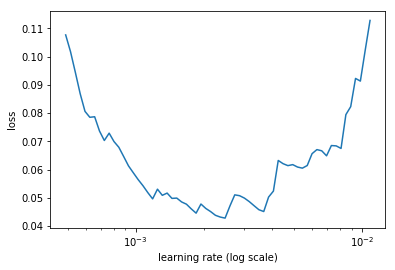

In [26]:
lrf = learn.lr_find(lr/100)
learn.sched.plot()

  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:44,  4.77it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:08,  3.08it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:34,  6.01it/s, loss=tensor(1.00000e-02 *
       1.3776, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


  1%|          | 2/212 [00:00<00:48,  4.32it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:32,  6.43it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:41,  5.03it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:31,  6.65it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:38,  5.45it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:30,  6.72it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:35,  5.83it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:00<00:29,  6.96it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:01<00:34,  5.95it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:29,  6.93it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:33,  6.18it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:29,  7.01it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:32,  6.35it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 9/212 [00:01<00:28,  

 31%|███       | 66/212 [00:07<00:15,  9.29it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.57it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.46it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.36it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:14,  9.63it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:14,  9.52it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:15,  9.42it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.68it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.58it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.48it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.74it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.63it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.54it/s, loss=tensor(1.00000e-02 *
 36%|███▌      | 76/212 [

 66%|██████▌   | 140/212 [00:13<00:06, 10.48it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 140/212 [00:13<00:06, 10.41it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 140/212 [00:13<00:06, 10.34it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:13<00:06, 10.49it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:13<00:06, 10.42it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:13<00:06, 10.35it/s, loss=tensor(1.00000e-02 *
 68%|██████▊   | 144/212 [00:13<00:06, 10.50it/s, loss=tensor(1.00000e-02 *
 68%|██████▊   | 144/212 [00:13<00:06, 10.43it/s, loss=tensor(1.00000e-02 *
 68%|██████▊   | 144/212 [00:13<00:06, 10.37it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 146/212 [00:13<00:06, 10.51it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 146/212 [00:13<00:06, 10.44it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 146/212 [00:14<00:06, 10.38it/s, loss=tensor(1.00000e-02 *
 70%|██████▉   | 148/212 [00:14<00:06, 10.52it/s, loss=tensor(1.00000e-02 *
 70%|██████▉

100%|██████████| 212/212 [00:19<00:00, 10.78it/s, loss=tensor(1.00000e-02 *
epoch      trn_loss   val_loss   accuracy                                                                   
    0      0.042851   0.097561   0.958491  
  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:47,  4.46it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:13,  2.88it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:37,  5.62it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:49,  4.25it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:32,  6.34it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:41,  5.04it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:31,  6.68it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:37,  5.49it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:30,  6.84it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:35,  5

 29%|██▉       | 61/212 [00:06<00:17,  8.83it/s, loss=tensor(1.00000e-02 *
 30%|██▉       | 63/212 [00:06<00:16,  9.12it/s, loss=tensor(1.00000e-02 *
 30%|██▉       | 63/212 [00:06<00:16,  9.01it/s, loss=tensor(1.00000e-02 *
 30%|██▉       | 63/212 [00:07<00:16,  8.91it/s, loss=tensor(1.00000e-02 *
 31%|███       | 65/212 [00:07<00:15,  9.19it/s, loss=tensor(1.00000e-02 *
 31%|███       | 65/212 [00:07<00:16,  9.09it/s, loss=tensor(1.00000e-02 *
 31%|███       | 65/212 [00:07<00:16,  8.98it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 67/212 [00:07<00:15,  9.26it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 67/212 [00:07<00:15,  9.16it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 67/212 [00:07<00:16,  9.05it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 69/212 [00:07<00:15,  9.32it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 69/212 [00:07<00:15,  9.22it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 69/212 [00:07<00:15,  9.12it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 71/212 [

 64%|██████▎   | 135/212 [00:12<00:07, 10.45it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.38it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.31it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.47it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.40it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.33it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 139/212 [00:13<00:06, 10.48it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 139/212 [00:13<00:07, 10.41it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 139/212 [00:13<00:07, 10.34it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 141/212 [00:13<00:06, 10.49it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 141/212 [00:13<00:06, 10.43it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 141/212 [00:13<00:06, 10.36it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 143/212 [00:13<00:06, 10.50it/s, loss=tensor(1.00000e-02 *
 67%|██████▋

 98%|█████████▊| 207/212 [00:18<00:00, 10.99it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:18<00:00, 10.93it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.88it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.99it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.94it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.89it/s, loss=tensor(1.00000e-02 *
100%|█████████▉| 211/212 [00:19<00:00, 10.99it/s, loss=tensor(1.00000e-02 *
100%|█████████▉| 211/212 [00:19<00:00, 10.95it/s, loss=tensor(1.00000e-02 *
    1      0.032771   0.105685   0.954717                                                                   
  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:56,  3.71it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:27,  2.40it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:44,  4.75it/s, loss=tensor(1.00000e-

 60%|██████    | 128/212 [00:13<00:08,  9.57it/s, loss=tensor(1.00000e-02 *
 60%|██████    | 128/212 [00:13<00:08,  9.51it/s, loss=tensor(1.00000e-02 *
 61%|██████▏   | 130/212 [00:13<00:08,  9.66it/s, loss=tensor(1.00000e-02 *
 61%|██████▏   | 130/212 [00:13<00:08,  9.60it/s, loss=tensor(1.00000e-02 *
 61%|██████▏   | 130/212 [00:13<00:08,  9.54it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 132/212 [00:13<00:08,  9.68it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 132/212 [00:13<00:08,  9.63it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 132/212 [00:13<00:08,  9.57it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:13<00:08,  9.72it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:13<00:08,  9.66it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:13<00:08,  9.60it/s, loss=tensor(1.00000e-02 *
 64%|██████▍   | 136/212 [00:13<00:07,  9.75it/s, loss=tensor(1.00000e-02 *
 64%|██████▍   | 136/212 [00:14<00:07,  9.69it/s, loss=tensor(1.00000e-02 *
 64%|██████▍

 94%|█████████▍| 200/212 [00:19<00:01, 10.41it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 200/212 [00:19<00:01, 10.36it/s, loss=tensor(1.00000e-02 *
 95%|█████████▌| 202/212 [00:19<00:00, 10.46it/s, loss=tensor(1.00000e-02 *
 95%|█████████▌| 202/212 [00:19<00:00, 10.42it/s, loss=tensor(1.00000e-02 *
 95%|█████████▌| 202/212 [00:19<00:00, 10.38it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 204/212 [00:19<00:00, 10.48it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 204/212 [00:19<00:00, 10.44it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 204/212 [00:19<00:00, 10.39it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:19<00:00, 10.50it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:19<00:00, 10.45it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:19<00:00, 10.41it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 208/212 [00:19<00:00, 10.51it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 208/212 [00:19<00:00, 10.47it/s, loss=tensor(1.00000e-02 *
 98%|███████

 23%|██▎       | 49/212 [00:06<00:22,  7.33it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:06<00:22,  7.24it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:06<00:21,  7.53it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:06<00:21,  7.45it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:06<00:21,  7.36it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:06<00:20,  7.65it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:21,  7.56it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:21,  7.47it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:20,  7.75it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:20,  7.67it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:20,  7.58it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 57/212 [00:07<00:19,  7.86it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 57/212 [00:07<00:19,  7.78it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 57/212 [

 57%|█████▋    | 121/212 [00:12<00:09,  9.62it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:12<00:09,  9.78it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:12<00:09,  9.71it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:12<00:09,  9.65it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:12<00:08,  9.81it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:12<00:08,  9.75it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:12<00:08,  9.69it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:12<00:08,  9.84it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:12<00:08,  9.78it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:13<00:08,  9.72it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:13<00:08,  9.87it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:13<00:08,  9.81it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:13<00:08,  9.75it/s, loss=tensor(1.00000e-02 *
 62%|██████▏

 91%|█████████ | 193/212 [00:18<00:01, 10.50it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:18<00:01, 10.60it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:18<00:01, 10.56it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:18<00:01, 10.51it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:18<00:01, 10.62it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:18<00:01, 10.57it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:18<00:01, 10.53it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:18<00:01, 10.63it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:18<00:01, 10.59it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:18<00:01, 10.54it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:18<00:01, 10.65it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:18<00:01, 10.60it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:19<00:01, 10.56it/s, loss=tensor(1.00000e-02 *
 96%|███████

 20%|██        | 43/212 [00:06<00:24,  6.80it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:23,  7.12it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:23,  7.03it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:24,  6.94it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:06<00:22,  7.25it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:06<00:23,  7.16it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:06<00:23,  7.08it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:06<00:22,  7.38it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:06<00:22,  7.29it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:06<00:22,  7.20it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:06<00:21,  7.49it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:06<00:21,  7.41it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:06<00:21,  7.32it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [

 55%|█████▌    | 117/212 [00:12<00:09,  9.60it/s, loss=tensor(1.00000e-02 *
 55%|█████▌    | 117/212 [00:12<00:09,  9.54it/s, loss=tensor(1.00000e-02 *
 55%|█████▌    | 117/212 [00:12<00:10,  9.48it/s, loss=tensor(1.00000e-02 *
 56%|█████▌    | 119/212 [00:12<00:09,  9.64it/s, loss=tensor(1.00000e-02 *
 56%|█████▌    | 119/212 [00:12<00:09,  9.57it/s, loss=tensor(1.00000e-02 *
 56%|█████▌    | 119/212 [00:12<00:09,  9.51it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:12<00:09,  9.67it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:12<00:09,  9.61it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:12<00:09,  9.55it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:12<00:09,  9.71it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:12<00:09,  9.65it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:12<00:09,  9.59it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:12<00:08,  9.74it/s, loss=tensor(1.00000e-02 *
 59%|█████▉ 

 89%|████████▉ | 189/212 [00:17<00:02, 10.51it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:18<00:02, 10.46it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:18<00:02, 10.42it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:18<00:01, 10.53it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:18<00:02, 10.48it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:18<00:02, 10.44it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:18<00:01, 10.54it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:18<00:01, 10.50it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:18<00:01, 10.45it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:18<00:01, 10.56it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:18<00:01, 10.52it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:18<00:01, 10.47it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:18<00:01, 10.58it/s, loss=tensor(1.00000e-02 *
 93%|███████

 18%|█▊        | 38/212 [00:05<00:26,  6.57it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 38/212 [00:05<00:26,  6.48it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 38/212 [00:05<00:27,  6.39it/s, loss=tensor(1.00000e-02 *
 19%|█▉        | 40/212 [00:05<00:25,  6.72it/s, loss=tensor(1.00000e-02 *
 19%|█▉        | 40/212 [00:06<00:25,  6.63it/s, loss=tensor(1.00000e-02 *
 19%|█▉        | 40/212 [00:06<00:26,  6.54it/s, loss=tensor(1.00000e-02 *
 20%|█▉        | 42/212 [00:06<00:24,  6.87it/s, loss=tensor(1.00000e-02 *
 20%|█▉        | 42/212 [00:06<00:25,  6.78it/s, loss=tensor(1.00000e-02 *
 20%|█▉        | 42/212 [00:06<00:25,  6.69it/s, loss=tensor(1.00000e-02 *
 21%|██        | 44/212 [00:06<00:23,  7.01it/s, loss=tensor(1.00000e-02 *
 21%|██        | 44/212 [00:06<00:24,  6.92it/s, loss=tensor(1.00000e-02 *
 21%|██        | 44/212 [00:06<00:24,  6.84it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 46/212 [00:06<00:23,  7.15it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 46/212 [

 86%|████████▌ | 182/212 [00:18<00:03, 10.00it/s, loss=tensor(1.00000e-02 *
 86%|████████▌ | 182/212 [00:18<00:03,  9.95it/s, loss=tensor(1.00000e-02 *
 87%|████████▋ | 184/212 [00:18<00:02, 10.06it/s, loss=tensor(1.00000e-02 *
 87%|████████▋ | 184/212 [00:18<00:02, 10.01it/s, loss=tensor(1.00000e-02 *
 87%|████████▋ | 184/212 [00:18<00:02,  9.97it/s, loss=tensor(1.00000e-02 *
 88%|████████▊ | 186/212 [00:18<00:02, 10.07it/s, loss=tensor(1.00000e-02 *
 88%|████████▊ | 186/212 [00:18<00:02, 10.03it/s, loss=tensor(1.00000e-02 *
 88%|████████▊ | 186/212 [00:18<00:02,  9.98it/s, loss=tensor(1.00000e-02 *
 89%|████████▊ | 188/212 [00:18<00:02, 10.09it/s, loss=tensor(1.00000e-02 *
 89%|████████▊ | 188/212 [00:18<00:02, 10.04it/s, loss=tensor(1.00000e-02 *
 89%|████████▊ | 188/212 [00:18<00:02, 10.00it/s, loss=tensor(1.00000e-02 *
 90%|████████▉ | 190/212 [00:18<00:02, 10.10it/s, loss=tensor(1.00000e-02 *
 90%|████████▉ | 190/212 [00:18<00:02, 10.05it/s, loss=tensor(1.00000e-02 *
 90%|███████

 15%|█▌        | 32/212 [00:05<00:30,  5.85it/s, loss=tensor(1.00000e-02 *
 15%|█▌        | 32/212 [00:05<00:31,  5.69it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 33/212 [00:05<00:30,  5.86it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 33/212 [00:05<00:31,  5.70it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 34/212 [00:05<00:30,  5.87it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 34/212 [00:05<00:31,  5.71it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 35/212 [00:05<00:30,  5.87it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 35/212 [00:06<00:30,  5.73it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 36/212 [00:06<00:29,  5.88it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 36/212 [00:06<00:30,  5.77it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:29,  5.92it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:29,  5.84it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:30,  5.77it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 39/212 [

 83%|████████▎ | 175/212 [00:18<00:03,  9.70it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 175/212 [00:18<00:03,  9.66it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 175/212 [00:18<00:03,  9.61it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 177/212 [00:18<00:03,  9.72it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 177/212 [00:18<00:03,  9.67it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 177/212 [00:18<00:03,  9.63it/s, loss=tensor(1.00000e-02 *
 84%|████████▍ | 179/212 [00:18<00:03,  9.74it/s, loss=tensor(1.00000e-02 *
 84%|████████▍ | 179/212 [00:18<00:03,  9.69it/s, loss=tensor(1.00000e-02 *
 84%|████████▍ | 179/212 [00:18<00:03,  9.65it/s, loss=tensor(1.00000e-02 *
 85%|████████▌ | 181/212 [00:18<00:03,  9.76it/s, loss=tensor(1.00000e-02 *
 85%|████████▌ | 181/212 [00:18<00:03,  9.72it/s, loss=tensor(1.00000e-02 *
 85%|████████▌ | 181/212 [00:18<00:03,  9.67it/s, loss=tensor(1.00000e-02 *
 86%|████████▋ | 183/212 [00:18<00:02,  9.78it/s, loss=tensor(1.00000e-02 *
 86%|███████

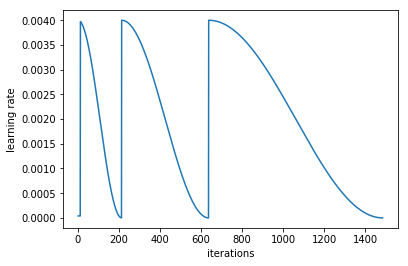

In [27]:
learn.save('great')
learn.load('great')
lr = 0.004
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.sched.plot_lr()

In [28]:
learn.save('cool')
learn.load('cool')


In [30]:
data.val_y

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 

In [31]:
data.classes

['0.0', '1.0']

In [32]:
#We see that our training loss is decreasing but not our validation loss,so we got to tweak somewhere....


# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape


(793, 2)

In [33]:
log_preds[0:5,:]

array([[ -0.07743,  -2.5969 ],
       [ -7.89644,  -0.00037],
       [-16.68207,   0.     ],
       [ -0.006  ,  -5.11854],
       [ -0.02189,  -3.83263]], dtype=float32)

In [34]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])  

In [37]:
probs[0:4]

array([0.0745 , 0.99963, 1.     , 0.00598], dtype=float32)

In [38]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))        

Correctly classified


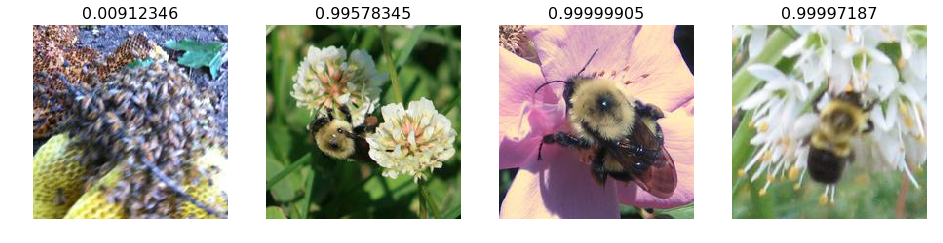

In [39]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


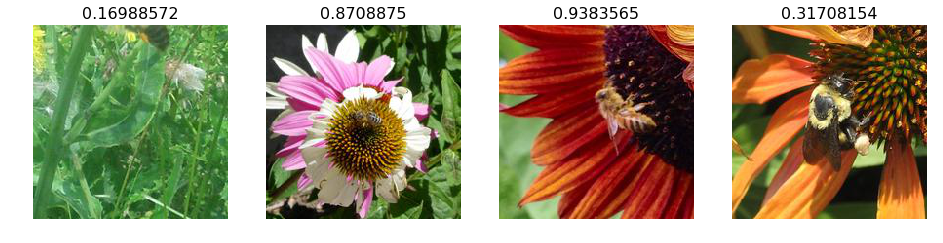

In [40]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [41]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct o's


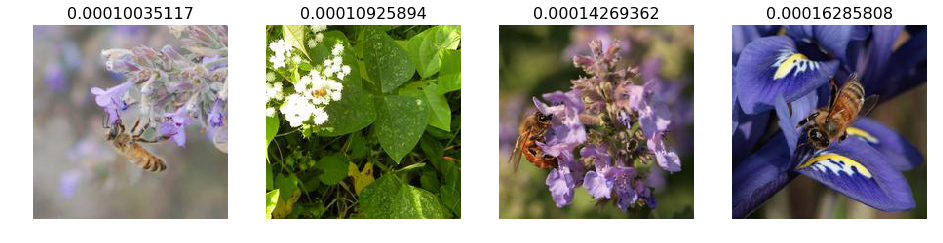

In [42]:
plot_val_with_title(most_by_correct(0, True), "Most correct o's")

Most correct 1's


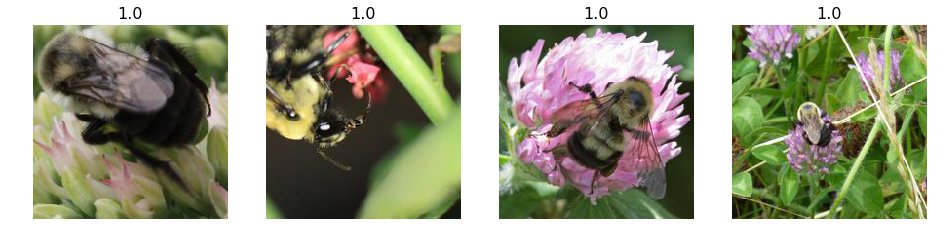

In [43]:
plot_val_with_title(most_by_correct(1, True), "Most correct 1's")
    

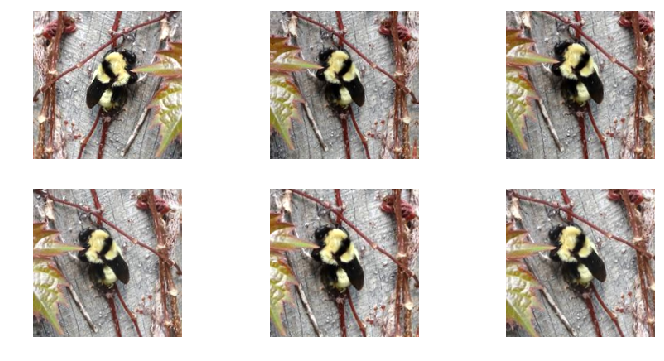

In [44]:
tfms = tfms_from_model(resnet34, 180, aug_tfms=transforms_side_on, max_zoom=1.1)
def get_augs():
    data = ImageClassifierData.from_csv(PATH,'train',f'{PATH}train_labels.csv',
                                    tfms = tfms,bs = 2,suffix = '.jpg',val_idxs = val_idxs,test_name='test')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [45]:
bs = 20
sz = 200
arch = resnet34
tfms = tfms_from_model(arch ,sz,aug_tfms = transforms_side_on,max_zoom = 1.1)
data = ImageClassifierData.from_csv(PATH,'train',f'{PATH}train_labels.csv',
                                    tfms = tfms,bs = bs,suffix = '.jpg',val_idxs = val_idxs,test_name='test')

In [47]:
learn.load('cool')

  0%|          | 1/212 [00:00<01:11,  2.94it/s, loss=tensor(1.00000e-02 *e='cuda:0')]
  1%|          | 2/212 [00:00<00:35,  5.84it/s, loss=tensor(1.00000e-02 *
       5.2292, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


  1%|          | 2/212 [00:00<00:48,  4.31it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:32,  6.42it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:41,  5.07it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:31,  6.71it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:38,  5.39it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:30,  6.70it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:35,  5.75it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:00<00:30,  6.81it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:00<00:34,  6.05it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:29,  6.98it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:33,  6.21it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:28,  7.07it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:31,  6.44it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 9/212 [00:01<00:28,  

 32%|███▏      | 68/212 [00:07<00:15,  9.55it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.45it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.34it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:14,  9.62it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:14,  9.51it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:15,  9.41it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.67it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.57it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.47it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.73it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.62it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.52it/s, loss=tensor(1.00000e-02 *
 36%|███▌      | 76/212 [00:07<00:13,  9.78it/s, loss=tensor(1.00000e-02 *
 36%|███▌      | 76/212 [

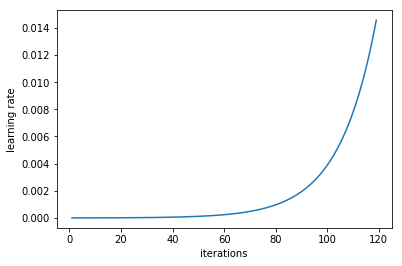

 56%|█████▌    | 118/212 [00:30<00:23,  3.93it/s, loss=tensor(1.00000e-02 *
       8.0093, device='cuda:0')]

In [48]:
lrf = learn.lr_find(lr/1000)
learn.sched.plot_lr()

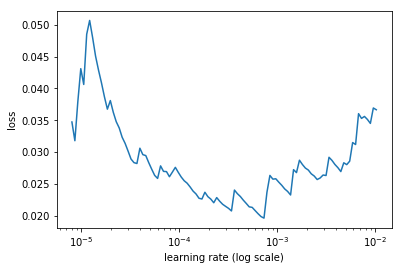

In [50]:

learn.sched.plot()

In [52]:
learn.load('cool')
learn.fit(lrs,4,cycle_len=1,cycle_mult=2)

  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:40,  5.17it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:08,  3.09it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:34,  6.05it/s, loss=tensor(1.00000e-02 *
       1.0122, device='cuda:0')]

/home/vinay/fastai/courses/dl1/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


  1%|          | 2/212 [00:00<00:46,  4.53it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:31,  6.66it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:38,  5.38it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:29,  7.08it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:36,  5.76it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:28,  7.18it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:33,  6.10it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:00<00:28,  7.26it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:00<00:32,  6.33it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:00<00:27,  7.33it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:31,  6.53it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:27,  7.45it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:30,  6.74it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 9/212 [00:01<00:26,  

 31%|███       | 66/212 [00:07<00:15,  9.22it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.50it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.39it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 68/212 [00:07<00:15,  9.29it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:14,  9.56it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:15,  9.45it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 70/212 [00:07<00:15,  9.35it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.62it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.51it/s, loss=tensor(1.00000e-02 *
 34%|███▍      | 72/212 [00:07<00:14,  9.40it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.66it/s, loss=tensor(1.00000e-02 *
 35%|███▍      | 74/212 [00:07<00:14,  9.55it/s, loss=tensor(1.00000e-02 *
       4.8797, device='cuda:0')]
 35%|███▍      | 74/212 [00:07<00:14,  9.44it/s, loss=tensor(1.0000

 99%|█████████▉| 210/212 [00:19<00:00, 10.78it/s, loss=tensor(1.00000e-02 *
100%|██████████| 212/212 [00:19<00:00, 10.88it/s, loss=tensor(1.00000e-02 *
epoch      trn_loss   val_loss   accuracy                                                                   
    0      0.020119   0.103115   0.958491  
  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:52,  4.01it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:20,  2.61it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:40,  5.16it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:53,  3.92it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:35,  5.82it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:44,  4.67it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:33,  6.12it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:39,  5.25it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:32, 

 29%|██▉       | 61/212 [00:07<00:17,  8.66it/s, loss=tensor(1.00000e-02 *
 29%|██▉       | 61/212 [00:07<00:17,  8.55it/s, loss=tensor(1.00000e-02 *
 30%|██▉       | 63/212 [00:07<00:16,  8.83it/s, loss=tensor(1.00000e-02 *
 30%|██▉       | 63/212 [00:07<00:17,  8.73it/s, loss=tensor(1.00000e-02 *
 30%|██▉       | 63/212 [00:07<00:17,  8.64it/s, loss=tensor(1.00000e-02 *
 31%|███       | 65/212 [00:07<00:16,  8.91it/s, loss=tensor(1.00000e-02 *
 31%|███       | 65/212 [00:07<00:16,  8.81it/s, loss=tensor(1.00000e-02 *
 31%|███       | 65/212 [00:07<00:16,  8.71it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 67/212 [00:07<00:16,  8.98it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 67/212 [00:07<00:16,  8.88it/s, loss=tensor(1.00000e-02 *
 32%|███▏      | 67/212 [00:07<00:16,  8.79it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 69/212 [00:07<00:15,  9.05it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 69/212 [00:07<00:15,  8.96it/s, loss=tensor(1.00000e-02 *
 33%|███▎      | 69/212 [

 63%|██████▎   | 133/212 [00:13<00:07, 10.03it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.18it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.11it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.05it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.20it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.14it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.07it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 139/212 [00:13<00:07, 10.22it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 139/212 [00:13<00:07, 10.15it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 139/212 [00:13<00:07, 10.09it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 141/212 [00:13<00:06, 10.23it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 141/212 [00:13<00:06, 10.17it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 141/212 [00:13<00:07, 10.11it/s, loss=tensor(1.00000e-02 *
 67%|██████▋

 97%|█████████▋| 205/212 [00:19<00:00, 10.60it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.70it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.66it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.61it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.71it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.66it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.62it/s, loss=tensor(1.00000e-02 *
100%|█████████▉| 211/212 [00:19<00:00, 10.72it/s, loss=tensor(1.00000e-02 *
100%|█████████▉| 211/212 [00:19<00:00, 10.68it/s, loss=tensor(1.00000e-02 *
    1      0.019183   0.101214   0.959748                                                                   
  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<00:49,  4.28it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:17,  2.72it/s, loss=tensor(1.00000

 61%|██████    | 129/212 [00:12<00:08, 10.10it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:12<00:08, 10.03it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:12<00:07, 10.18it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:12<00:08, 10.12it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:13<00:08, 10.05it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 133/212 [00:13<00:07, 10.21it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 133/212 [00:13<00:07, 10.14it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 133/212 [00:13<00:07, 10.08it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.23it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.16it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:13<00:07, 10.10it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.25it/s, loss=tensor(1.00000e-02 *
 65%|██████▍   | 137/212 [00:13<00:07, 10.19it/s, loss=tensor(1.00000e-02 *
 65%|██████▍

 95%|█████████▍| 201/212 [00:18<00:01, 10.64it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:18<00:01, 10.59it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:18<00:00, 10.69it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:19<00:00, 10.64it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:19<00:00, 10.60it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 205/212 [00:19<00:00, 10.70it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 205/212 [00:19<00:00, 10.65it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 205/212 [00:19<00:00, 10.60it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.71it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.66it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:19<00:00, 10.61it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.71it/s, loss=tensor(1.00000e-02 *
 99%|█████████▊| 209/212 [00:19<00:00, 10.66it/s, loss=tensor(1.00000e-02 *
 99%|███████

 23%|██▎       | 49/212 [00:07<00:24,  6.75it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:22,  7.02it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  6.94it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  6.87it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:22,  7.14it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:22,  7.05it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [00:07<00:22,  6.98it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:21,  7.24it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:21,  7.16it/s, loss=tensor(1.00000e-02 *
 26%|██▌       | 55/212 [00:07<00:22,  7.08it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 57/212 [00:07<00:21,  7.34it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 57/212 [00:07<00:21,  7.26it/s, loss=tensor(1.00000e-02 *
 27%|██▋       | 57/212 [00:07<00:21,  7.18it/s, loss=tensor(1.00000e-02 *
 28%|██▊       | 59/212 [

 58%|█████▊    | 123/212 [00:13<00:09,  9.20it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  9.14it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  9.09it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  9.23it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  9.18it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  9.12it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:13<00:09,  9.27it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:13<00:09,  9.21it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:13<00:09,  9.15it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:13<00:08,  9.30it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:13<00:08,  9.24it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:14<00:09,  9.19it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:14<00:08,  9.33it/s, loss=tensor(1.00000e-02 *
 62%|██████▏

 92%|█████████▏| 195/212 [00:19<00:01, 10.01it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:19<00:01,  9.96it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:19<00:01,  9.92it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:19<00:01, 10.02it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:19<00:01,  9.98it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:19<00:01,  9.94it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:19<00:01, 10.04it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:19<00:01,  9.99it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:19<00:01,  9.95it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:19<00:01, 10.05it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:20<00:01, 10.00it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:20<00:01,  9.96it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:20<00:00, 10.06it/s, loss=tensor(1.00000e-02 *
 96%|███████

 20%|██        | 43/212 [00:06<00:26,  6.28it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:25,  6.57it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:25,  6.48it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:07<00:26,  6.41it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:07<00:24,  6.69it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:07<00:24,  6.61it/s, loss=tensor(1.00000e-02 *
 22%|██▏       | 47/212 [00:07<00:25,  6.53it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:07<00:23,  6.81it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:07<00:24,  6.73it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 49/212 [00:07<00:24,  6.65it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  6.92it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  6.84it/s, loss=tensor(1.00000e-02 *
 24%|██▍       | 51/212 [00:07<00:23,  6.77it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 53/212 [

 55%|█████▌    | 117/212 [00:12<00:10,  9.01it/s, loss=tensor(1.00000e-02 *
 55%|█████▌    | 117/212 [00:13<00:10,  8.95it/s, loss=tensor(1.00000e-02 *
 55%|█████▌    | 117/212 [00:13<00:10,  8.90it/s, loss=tensor(1.00000e-02 *
 56%|█████▌    | 119/212 [00:13<00:10,  9.05it/s, loss=tensor(1.00000e-02 *
 56%|█████▌    | 119/212 [00:13<00:10,  8.99it/s, loss=tensor(1.00000e-02 *
 56%|█████▌    | 119/212 [00:13<00:10,  8.94it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:13<00:10,  9.08it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:13<00:10,  9.02it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 121/212 [00:13<00:10,  8.97it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  9.12it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  9.06it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 123/212 [00:13<00:09,  9.00it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 125/212 [00:13<00:09,  9.15it/s, loss=tensor(1.00000e-02 *
 59%|█████▉ 

 89%|████████▉ | 189/212 [00:19<00:02,  9.90it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:19<00:02,  9.86it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:19<00:02,  9.81it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:19<00:02,  9.92it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:19<00:02,  9.87it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:19<00:02,  9.83it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:19<00:01,  9.93it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:19<00:01,  9.89it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:19<00:01,  9.84it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:19<00:01,  9.94it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:19<00:01,  9.90it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:19<00:01,  9.86it/s, loss=tensor(1.00000e-02 *
 93%|█████████▎| 197/212 [00:19<00:01,  9.96it/s, loss=tensor(1.00000e-02 *
 93%|███████

 17%|█▋        | 37/212 [00:06<00:29,  5.94it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:29,  5.86it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 39/212 [00:06<00:27,  6.18it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 39/212 [00:06<00:28,  6.10it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 39/212 [00:06<00:28,  6.02it/s, loss=tensor(1.00000e-02 *
 19%|█▉        | 41/212 [00:06<00:27,  6.33it/s, loss=tensor(1.00000e-02 *
 19%|█▉        | 41/212 [00:06<00:27,  6.25it/s, loss=tensor(1.00000e-02 *
 19%|█▉        | 41/212 [00:06<00:27,  6.17it/s, loss=tensor(1.00000e-02 *
 20%|██        | 43/212 [00:06<00:26,  6.47it/s, loss=tensor(1.00000e-02 *
 20%|██        | 43/212 [00:06<00:26,  6.39it/s, loss=tensor(1.00000e-02 *
 20%|██        | 43/212 [00:06<00:26,  6.31it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:25,  6.60it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [00:06<00:25,  6.52it/s, loss=tensor(1.00000e-02 *
 21%|██        | 45/212 [

 85%|████████▌ | 181/212 [00:18<00:03,  9.75it/s, loss=tensor(1.00000e-02 *
 86%|████████▋ | 183/212 [00:18<00:02,  9.85it/s, loss=tensor(1.00000e-02 *
 86%|████████▋ | 183/212 [00:18<00:02,  9.81it/s, loss=tensor(1.00000e-02 *
 86%|████████▋ | 183/212 [00:18<00:02,  9.76it/s, loss=tensor(1.00000e-02 *
 87%|████████▋ | 185/212 [00:18<00:02,  9.87it/s, loss=tensor(1.00000e-02 *
 87%|████████▋ | 185/212 [00:18<00:02,  9.82it/s, loss=tensor(1.00000e-02 *
 87%|████████▋ | 185/212 [00:18<00:02,  9.78it/s, loss=tensor(1.00000e-02 *
 88%|████████▊ | 187/212 [00:18<00:02,  9.89it/s, loss=tensor(1.00000e-02 *
 88%|████████▊ | 187/212 [00:18<00:02,  9.84it/s, loss=tensor(1.00000e-02 *
 88%|████████▊ | 187/212 [00:19<00:02,  9.80it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:19<00:02,  9.90it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:19<00:02,  9.86it/s, loss=tensor(1.00000e-02 *
 89%|████████▉ | 189/212 [00:19<00:02,  9.82it/s, loss=tensor(1.00000e-02 *
 90%|███████

 15%|█▌        | 32/212 [00:05<00:31,  5.80it/s, loss=tensor(1.00000e-02 *
 15%|█▌        | 32/212 [00:05<00:31,  5.63it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 33/212 [00:05<00:30,  5.80it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 33/212 [00:05<00:31,  5.64it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 34/212 [00:05<00:30,  5.80it/s, loss=tensor(1.00000e-02 *
 16%|█▌        | 34/212 [00:06<00:31,  5.66it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 35/212 [00:06<00:30,  5.83it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 35/212 [00:06<00:30,  5.74it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 35/212 [00:06<00:31,  5.66it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:29,  5.98it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:29,  5.90it/s, loss=tensor(1.00000e-02 *
 17%|█▋        | 37/212 [00:06<00:30,  5.83it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 39/212 [00:06<00:28,  6.14it/s, loss=tensor(1.00000e-02 *
 18%|█▊        | 39/212 [

 83%|████████▎ | 175/212 [00:18<00:03,  9.72it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 175/212 [00:18<00:03,  9.67it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 177/212 [00:18<00:03,  9.78it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 177/212 [00:18<00:03,  9.73it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 177/212 [00:18<00:03,  9.69it/s, loss=tensor(1.00000e-02 *
 84%|████████▍ | 179/212 [00:18<00:03,  9.80it/s, loss=tensor(1.00000e-02 *
 84%|████████▍ | 179/212 [00:18<00:03,  9.75it/s, loss=tensor(1.00000e-02 *
 84%|████████▍ | 179/212 [00:18<00:03,  9.71it/s, loss=tensor(1.00000e-02 *
 85%|████████▌ | 181/212 [00:18<00:03,  9.81it/s, loss=tensor(1.00000e-02 *
 85%|████████▌ | 181/212 [00:18<00:03,  9.77it/s, loss=tensor(1.00000e-02 *
 85%|████████▌ | 181/212 [00:18<00:03,  9.72it/s, loss=tensor(1.00000e-02 *
 86%|████████▋ | 183/212 [00:18<00:02,  9.83it/s, loss=tensor(1.00000e-02 *
 86%|████████▋ | 183/212 [00:18<00:02,  9.78it/s, loss=tensor(1.00000e-02 *
 86%|███████

 45%|████▍     | 95/212 [00:11<00:13,  8.41it/s, loss=tensor(1.00000e-02 *
 46%|████▌     | 97/212 [00:11<00:13,  8.59it/s, loss=tensor(1.00000e-02 *
 46%|████▌     | 97/212 [00:11<00:13,  8.52it/s, loss=tensor(1.00000e-02 *
 46%|████▌     | 97/212 [00:11<00:13,  8.46it/s, loss=tensor(1.00000e-02 *
 47%|████▋     | 99/212 [00:11<00:13,  8.63it/s, loss=tensor(1.00000e-02 *
 47%|████▋     | 99/212 [00:11<00:13,  8.57it/s, loss=tensor(1.00000e-02 *
 47%|████▋     | 99/212 [00:11<00:13,  8.51it/s, loss=tensor(1.00000e-02 *
 48%|████▊     | 101/212 [00:11<00:12,  8.68it/s, loss=tensor(1.00000e-02 *
 48%|████▊     | 101/212 [00:11<00:12,  8.61it/s, loss=tensor(1.00000e-02 *
 48%|████▊     | 101/212 [00:11<00:12,  8.55it/s, loss=tensor(1.00000e-02 *
 49%|████▊     | 103/212 [00:11<00:12,  8.72it/s, loss=tensor(1.00000e-02 *
 49%|████▊     | 103/212 [00:11<00:12,  8.66it/s, loss=tensor(1.00000e-02 *
 49%|████▊     | 103/212 [00:11<00:12,  8.60it/s, loss=tensor(1.00000e-02 *
 50%|████▉     | 10

 79%|███████▉  | 167/212 [00:17<00:04,  9.59it/s, loss=tensor(1.00000e-02 *
 80%|███████▉  | 169/212 [00:17<00:04,  9.70it/s, loss=tensor(1.00000e-02 *
 80%|███████▉  | 169/212 [00:17<00:04,  9.65it/s, loss=tensor(1.00000e-02 *
 80%|███████▉  | 169/212 [00:17<00:04,  9.61it/s, loss=tensor(1.00000e-02 *
 81%|████████  | 171/212 [00:17<00:04,  9.72it/s, loss=tensor(1.00000e-02 *
 81%|████████  | 171/212 [00:17<00:04,  9.67it/s, loss=tensor(1.00000e-02 *
 81%|████████  | 171/212 [00:17<00:04,  9.63it/s, loss=tensor(1.00000e-02 *
 82%|████████▏ | 173/212 [00:17<00:04,  9.74it/s, loss=tensor(1.00000e-02 *
 82%|████████▏ | 173/212 [00:17<00:04,  9.69it/s, loss=tensor(1.00000e-02 *
 82%|████████▏ | 173/212 [00:17<00:04,  9.65it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 175/212 [00:17<00:03,  9.76it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 175/212 [00:18<00:03,  9.71it/s, loss=tensor(1.00000e-02 *
 83%|████████▎ | 175/212 [00:18<00:03,  9.67it/s, loss=tensor(1.00000e-02 *
 83%|███████

 42%|████▏     | 88/212 [00:10<00:14,  8.27it/s, loss=tensor(1.00000e-02 *
 42%|████▏     | 90/212 [00:10<00:14,  8.46it/s, loss=tensor(1.00000e-02 *
 42%|████▏     | 90/212 [00:10<00:14,  8.39it/s, loss=tensor(1.00000e-02 *
 42%|████▏     | 90/212 [00:10<00:14,  8.33it/s, loss=tensor(1.00000e-02 *
 43%|████▎     | 92/212 [00:10<00:14,  8.51it/s, loss=tensor(1.00000e-02 *
 43%|████▎     | 92/212 [00:10<00:14,  8.45it/s, loss=tensor(1.00000e-02 *
 43%|████▎     | 92/212 [00:10<00:14,  8.38it/s, loss=tensor(1.00000e-02 *
 44%|████▍     | 94/212 [00:10<00:13,  8.57it/s, loss=tensor(1.00000e-02 *
 44%|████▍     | 94/212 [00:11<00:13,  8.50it/s, loss=tensor(1.00000e-02 *
 44%|████▍     | 94/212 [00:11<00:13,  8.44it/s, loss=tensor(1.00000e-02 *
 45%|████▌     | 96/212 [00:11<00:13,  8.62it/s, loss=tensor(1.00000e-02 *
 45%|████▌     | 96/212 [00:11<00:13,  8.55it/s, loss=tensor(1.00000e-02 *
 45%|████▌     | 96/212 [00:11<00:13,  8.48it/s, loss=tensor(1.00000e-02 *
 46%|████▌     | 98/212 [

  7%|▋         | 15/212 [00:02<00:37,  5.22it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 16/212 [00:02<00:35,  5.53it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 16/212 [00:03<00:37,  5.27it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 17/212 [00:03<00:34,  5.59it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 17/212 [00:03<00:36,  5.34it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 18/212 [00:03<00:34,  5.63it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 18/212 [00:03<00:35,  5.39it/s, loss=tensor(1.00000e-02 *
  9%|▉         | 19/212 [00:03<00:33,  5.68it/s, loss=tensor(1.00000e-02 *
  9%|▉         | 19/212 [00:03<00:35,  5.44it/s, loss=tensor(1.00000e-02 *
  9%|▉         | 20/212 [00:03<00:33,  5.72it/s, loss=tensor(1.00000e-02 *
  9%|▉         | 20/212 [00:03<00:35,  5.48it/s, loss=tensor(1.00000e-02 *
 10%|▉         | 21/212 [00:03<00:33,  5.75it/s, loss=tensor(1.00000e-02 *
 10%|▉         | 21/212 [00:03<00:34,  5.49it/s, loss=tensor(1.00000e-02 *
 10%|█         | 22/212 [

 72%|███████▏  | 153/212 [00:16<00:06,  9.51it/s, loss=tensor(1.00000e-02 *
 72%|███████▏  | 153/212 [00:16<00:06,  9.46it/s, loss=tensor(1.00000e-02 *
 73%|███████▎  | 155/212 [00:16<00:05,  9.58it/s, loss=tensor(1.00000e-02 *
 73%|███████▎  | 155/212 [00:16<00:05,  9.53it/s, loss=tensor(1.00000e-02 *
 73%|███████▎  | 155/212 [00:16<00:06,  9.49it/s, loss=tensor(1.00000e-02 *
 74%|███████▍  | 157/212 [00:16<00:05,  9.61it/s, loss=tensor(1.00000e-02 *
 74%|███████▍  | 157/212 [00:16<00:05,  9.56it/s, loss=tensor(1.00000e-02 *
 74%|███████▍  | 157/212 [00:16<00:05,  9.51it/s, loss=tensor(1.00000e-02 *
 75%|███████▌  | 159/212 [00:16<00:05,  9.63it/s, loss=tensor(1.00000e-02 *
 75%|███████▌  | 159/212 [00:16<00:05,  9.58it/s, loss=tensor(1.00000e-02 *
 75%|███████▌  | 159/212 [00:16<00:05,  9.53it/s, loss=tensor(1.00000e-02 *
 76%|███████▌  | 161/212 [00:16<00:05,  9.65it/s, loss=tensor(1.00000e-02 *
 76%|███████▌  | 161/212 [00:16<00:05,  9.60it/s, loss=tensor(1.00000e-02 *
 76%|███████

  5%|▍         | 10/212 [00:01<00:37,  5.40it/s, loss=tensor(1.00000e-02 *
  5%|▍         | 10/212 [00:02<00:40,  4.93it/s, loss=tensor(1.00000e-02 *
  5%|▌         | 11/212 [00:02<00:37,  5.41it/s, loss=tensor(1.00000e-02 *
  5%|▌         | 11/212 [00:02<00:39,  5.03it/s, loss=tensor(1.00000e-02 *
  6%|▌         | 12/212 [00:02<00:36,  5.46it/s, loss=tensor(1.00000e-02 *
  6%|▌         | 12/212 [00:02<00:39,  5.06it/s, loss=tensor(1.00000e-02 *
  6%|▌         | 13/212 [00:02<00:36,  5.46it/s, loss=tensor(1.00000e-02 *
  6%|▌         | 13/212 [00:02<00:38,  5.13it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 14/212 [00:02<00:35,  5.50it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 14/212 [00:02<00:38,  5.14it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 15/212 [00:02<00:36,  5.45it/s, loss=tensor(1.00000e-02 *
  7%|▋         | 15/212 [00:02<00:37,  5.21it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 16/212 [00:02<00:35,  5.54it/s, loss=tensor(1.00000e-02 *
  8%|▊         | 16/212 [

 69%|██████▉   | 147/212 [00:15<00:06,  9.42it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 147/212 [00:15<00:06,  9.37it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 147/212 [00:15<00:06,  9.31it/s, loss=tensor(1.00000e-02 *
 70%|███████   | 149/212 [00:15<00:06,  9.44it/s, loss=tensor(1.00000e-02 *
 70%|███████   | 149/212 [00:15<00:06,  9.39it/s, loss=tensor(1.00000e-02 *
 70%|███████   | 149/212 [00:15<00:06,  9.34it/s, loss=tensor(1.00000e-02 *
 71%|███████   | 151/212 [00:15<00:06,  9.46it/s, loss=tensor(1.00000e-02 *
 71%|███████   | 151/212 [00:16<00:06,  9.41it/s, loss=tensor(1.00000e-02 *
 71%|███████   | 151/212 [00:16<00:06,  9.36it/s, loss=tensor(1.00000e-02 *
 72%|███████▏  | 153/212 [00:16<00:06,  9.49it/s, loss=tensor(1.00000e-02 *
 72%|███████▏  | 153/212 [00:16<00:06,  9.43it/s, loss=tensor(1.00000e-02 *
 72%|███████▏  | 153/212 [00:16<00:06,  9.38it/s, loss=tensor(1.00000e-02 *
 73%|███████▎  | 155/212 [00:16<00:05,  9.51it/s, loss=tensor(1.00000e-02 *
 73%|███████

  2%|▏         | 5/212 [00:01<00:44,  4.66it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:01<00:50,  4.10it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:01<00:42,  4.85it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:01<00:47,  4.30it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:41,  4.99it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 7/212 [00:01<00:45,  4.46it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:40,  5.02it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 8/212 [00:01<00:44,  4.58it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 9/212 [00:01<00:39,  5.14it/s, loss=tensor(1.00000e-02 *
  4%|▍         | 9/212 [00:01<00:43,  4.71it/s, loss=tensor(1.00000e-02 *
  5%|▍         | 10/212 [00:01<00:38,  5.20it/s, loss=tensor(1.00000e-02 *
  5%|▍         | 10/212 [00:02<00:41,  4.81it/s, loss=tensor(1.00000e-02 *
  5%|▌         | 11/212 [00:02<00:38,  5.25it/s, loss=tensor(1.00000e-02 *
  5%|▌         | 11/212 [00:02<00:4

 66%|██████▌   | 140/212 [00:15<00:07,  9.28it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 140/212 [00:15<00:07,  9.23it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:15<00:07,  9.36it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:15<00:07,  9.31it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:15<00:07,  9.26it/s, loss=tensor(1.00000e-02 *
 68%|██████▊   | 144/212 [00:15<00:07,  9.39it/s, loss=tensor(1.00000e-02 *
 68%|██████▊   | 144/212 [00:15<00:07,  9.34it/s, loss=tensor(1.00000e-02 *
 68%|██████▊   | 144/212 [00:15<00:07,  9.29it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 146/212 [00:15<00:07,  9.41it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 146/212 [00:15<00:07,  9.36it/s, loss=tensor(1.00000e-02 *
 69%|██████▉   | 146/212 [00:15<00:07,  9.31it/s, loss=tensor(1.00000e-02 *
 70%|██████▉   | 148/212 [00:15<00:06,  9.44it/s, loss=tensor(1.00000e-02 *
 70%|██████▉   | 148/212 [00:15<00:06,  9.39it/s, loss=tensor(1.00000e-02 *
 70%|██████▉

    11     0.011696   0.106835   0.957233                                                                   
  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:05,  3.24it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:43,  2.05it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<00:51,  4.06it/s, loss=tensor(1.00000e-02 *
  1%|          | 2/212 [00:00<01:05,  3.22it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:43,  4.79it/s, loss=tensor(1.00000e-02 *
  1%|▏         | 3/212 [00:00<00:54,  3.85it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:40,  5.08it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 4/212 [00:00<00:48,  4.30it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:00<00:39,  5.31it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 5/212 [00:01<00:45,  4.53it/s, loss=tensor(1.00000e-02 *
  3%|▎         | 6/212 [00:01<00:38,  5.42it/s, loss=tensor(1.00000e-02 *
  3%|▎     

 63%|██████▎   | 134/212 [00:14<00:08,  9.37it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:14<00:08,  9.31it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 134/212 [00:14<00:08,  9.26it/s, loss=tensor(1.00000e-02 *
 64%|██████▍   | 136/212 [00:14<00:08,  9.39it/s, loss=tensor(1.00000e-02 *
 64%|██████▍   | 136/212 [00:14<00:08,  9.34it/s, loss=tensor(1.00000e-02 *
 64%|██████▍   | 136/212 [00:14<00:08,  9.29it/s, loss=tensor(1.00000e-02 *
 65%|██████▌   | 138/212 [00:14<00:07,  9.42it/s, loss=tensor(1.00000e-02 *
 65%|██████▌   | 138/212 [00:14<00:07,  9.37it/s, loss=tensor(1.00000e-02 *
 65%|██████▌   | 138/212 [00:14<00:07,  9.31it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 140/212 [00:14<00:07,  9.45it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 140/212 [00:14<00:07,  9.39it/s, loss=tensor(1.00000e-02 *
 66%|██████▌   | 140/212 [00:14<00:07,  9.34it/s, loss=tensor(1.00000e-02 *
 67%|██████▋   | 142/212 [00:14<00:07,  9.47it/s, loss=tensor(1.00000e-02 *
 67%|██████▋

 97%|█████████▋| 206/212 [00:20<00:00, 10.11it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:20<00:00, 10.07it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 206/212 [00:20<00:00, 10.03it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 208/212 [00:20<00:00, 10.13it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 208/212 [00:20<00:00, 10.08it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 208/212 [00:20<00:00, 10.04it/s, loss=tensor(1.00000e-02 *
 99%|█████████▉| 210/212 [00:20<00:00, 10.14it/s, loss=tensor(1.00000e-02 *
 99%|█████████▉| 210/212 [00:20<00:00, 10.10it/s, loss=tensor(1.00000e-02 *
 99%|█████████▉| 210/212 [00:20<00:00, 10.07it/s, loss=tensor(1.00000e-02 *
100%|██████████| 212/212 [00:20<00:00, 10.16it/s, loss=tensor(1.00000e-02 *
    12     0.020651   0.104379   0.962264                                                                   
  0%|          | 0/212 [00:00<?, ?it/s, loss=tensor(1.00000e-02 *
  0%|          | 1/212 [00:00<01:04,  3.28it/s, loss=tensor(1.000

 60%|█████▉    | 127/212 [00:13<00:09,  9.17it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:13<00:09,  9.12it/s, loss=tensor(1.00000e-02 *
 60%|█████▉    | 127/212 [00:14<00:09,  9.06it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:14<00:09,  9.20it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:14<00:09,  9.15it/s, loss=tensor(1.00000e-02 *
 61%|██████    | 129/212 [00:14<00:09,  9.09it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:14<00:08,  9.23it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:14<00:08,  9.17it/s, loss=tensor(1.00000e-02 *
 62%|██████▏   | 131/212 [00:14<00:08,  9.12it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 133/212 [00:14<00:08,  9.26it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 133/212 [00:14<00:08,  9.20it/s, loss=tensor(1.00000e-02 *
 63%|██████▎   | 133/212 [00:14<00:08,  9.15it/s, loss=tensor(1.00000e-02 *
 64%|██████▎   | 135/212 [00:14<00:08,  9.29it/s, loss=tensor(1.00000e-02 *
 64%|██████▎

 94%|█████████▍| 199/212 [00:20<00:01,  9.94it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:20<00:01,  9.90it/s, loss=tensor(1.00000e-02 *
 94%|█████████▍| 199/212 [00:20<00:01,  9.86it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:20<00:01,  9.96it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:20<00:01,  9.91it/s, loss=tensor(1.00000e-02 *
 95%|█████████▍| 201/212 [00:20<00:01,  9.87it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:20<00:00,  9.97it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:20<00:00,  9.93it/s, loss=tensor(1.00000e-02 *
 96%|█████████▌| 203/212 [00:20<00:00,  9.89it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 205/212 [00:20<00:00,  9.98it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 205/212 [00:20<00:00,  9.94it/s, loss=tensor(1.00000e-02 *
 97%|█████████▋| 205/212 [00:20<00:00,  9.89it/s, loss=tensor(1.00000e-02 *
 98%|█████████▊| 207/212 [00:20<00:00,  9.99it/s, loss=tensor(1.00000e-02 *
 98%|███████

 23%|██▎       | 48/212 [00:07<00:24,  6.74it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 48/212 [00:07<00:24,  6.66it/s, loss=tensor(1.00000e-02 *
 23%|██▎       | 48/212 [00:07<00:24,  6.58it/s, loss=tensor(1.00000e-02 *
 24%|██▎       | 50/212 [00:07<00:23,  6.85it/s, loss=tensor(1.00000e-02 *
 24%|██▎       | 50/212 [00:07<00:23,  6.78it/s, loss=tensor(1.00000e-02 *
 24%|██▎       | 50/212 [00:07<00:24,  6.70it/s, loss=tensor(1.00000e-02 *
 25%|██▍       | 52/212 [00:07<00:22,  6.97it/s, loss=tensor(1.00000e-02 *
 25%|██▍       | 52/212 [00:07<00:23,  6.89it/s, loss=tensor(1.00000e-02 *
 25%|██▍       | 52/212 [00:07<00:23,  6.81it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 54/212 [00:07<00:22,  7.07it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 54/212 [00:07<00:22,  6.99it/s, loss=tensor(1.00000e-02 *
 25%|██▌       | 54/212 [00:07<00:22,  6.92it/s, loss=tensor(1.00000e-02 *
 26%|██▋       | 56/212 [00:07<00:21,  7.18it/s, loss=tensor(1.00000e-02 *
 26%|██▋       | 56/212 [

 57%|█████▋    | 120/212 [00:13<00:10,  8.99it/s, loss=tensor(1.00000e-02 *
 57%|█████▋    | 120/212 [00:13<00:10,  8.93it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 122/212 [00:13<00:09,  9.08it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 122/212 [00:13<00:09,  9.02it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 122/212 [00:13<00:10,  8.96it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 124/212 [00:13<00:09,  9.11it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 124/212 [00:13<00:09,  9.05it/s, loss=tensor(1.00000e-02 *
 58%|█████▊    | 124/212 [00:13<00:09,  8.99it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 126/212 [00:13<00:09,  9.14it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 126/212 [00:13<00:09,  9.08it/s, loss=tensor(1.00000e-02 *
 59%|█████▉    | 126/212 [00:13<00:09,  9.03it/s, loss=tensor(1.00000e-02 *
 60%|██████    | 128/212 [00:13<00:09,  9.17it/s, loss=tensor(1.00000e-02 *
 60%|██████    | 128/212 [00:14<00:09,  9.11it/s, loss=tensor(1.00000e-02 *
 60%|██████ 

 89%|████████▉ | 189/212 [00:21<00:02,  8.95it/s, loss=tensor(1.00000e-02 *
 90%|████████▉ | 190/212 [00:21<00:02,  9.00it/s, loss=tensor(1.00000e-02 *
 90%|████████▉ | 190/212 [00:21<00:02,  8.94it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:21<00:02,  8.99it/s, loss=tensor(1.00000e-02 *
 90%|█████████ | 191/212 [00:21<00:02,  8.94it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 192/212 [00:21<00:02,  8.98it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 192/212 [00:21<00:02,  8.93it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:21<00:02,  8.98it/s, loss=tensor(1.00000e-02 *
 91%|█████████ | 193/212 [00:21<00:02,  8.92it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 194/212 [00:21<00:02,  8.96it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 194/212 [00:21<00:02,  8.91it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:21<00:01,  8.95it/s, loss=tensor(1.00000e-02 *
 92%|█████████▏| 195/212 [00:21<00:01,  8.90it/s, loss=tensor(1.00000e-02 *
 92%|███████

[0.10259007, 0.9584906]

## we got an accuracy of 96.22 befor stalling.We haven't employed too many tricks yet except differentiable learning rate and cyclical learning rates.